# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import wandb
import pandas as pd
import scipy.io

# Data Preprocessing

Training set size: 48000
Validation set size: 12000
Test set size: 10000
Count of 0 = 4750
Count of 1 = 5383
Count of 2 = 4777
Count of 3 = 4878
Count of 4 = 4641
Count of 5 = 4366
Count of 6 = 4715
Count of 7 = 5037
Count of 8 = 4679
Count of 9 = 4774


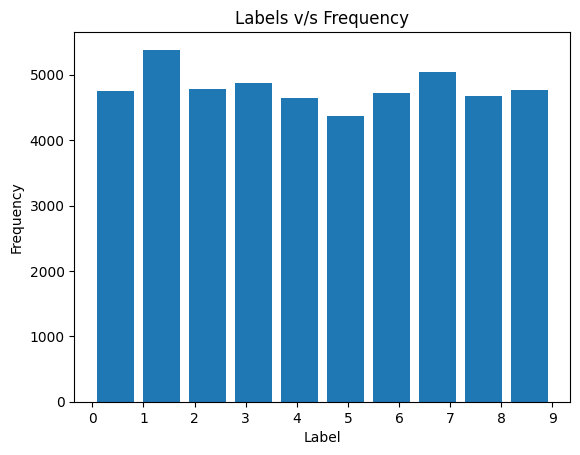

First 5 images of each label:


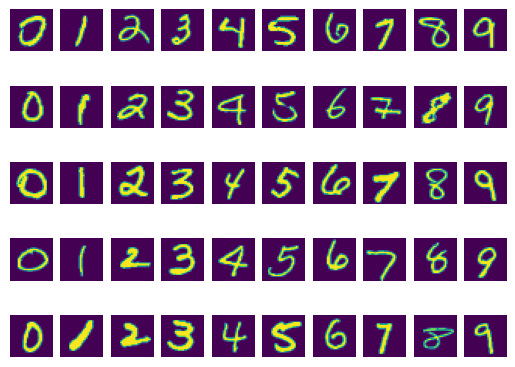

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
data = torchvision.datasets.MNIST('./mnist', train=True, transform=transform, download=True)
# split this data into training and validation sets
train, val = train_test_split(data, test_size=0.2)
test = torchvision.datasets.MNIST('./mnist', train=False, transform=transform, download=True)

print("Training set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

data2 = data
data = train

imgs = []
labels = []
for i in data:
    imgs.append(torchvision.transforms.ToPILImage()(i[0]))
    labels.append(i[1])

imgs = np.array(imgs)
labels = np.array(labels)

for i in range(10):
    labels2 = labels - i
    print("Count of", i, "=", len(labels) - np.count_nonzero(labels2))

x = np.arange(10)

plt.hist(labels, rwidth=0.8)
plt.title('Labels v/s Frequency')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(np.arange(10), [str(i) for i in range(10)])
plt.show()

count = np.zeros((10)).astype(int)

l = [[0 for i in range(5)] for j in range(10)]

for i in data:
    if (count[i[1]] < 5):
        l[i[1]][count[i[1]]] = i[0][0]
        count[i[1]] += 1

print("First 5 images of each label:")
for i in range(10):
    for j in range(5):
        plt.subplot(5, 10, i + j * 10 + 1)
        plt.imshow(l[i][j])
        plt.axis('off')

In [ ]:
def visualise_feature_maps():
    pass

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CNN Implementation

In [ ]:
d = {}
d[2, 1] = 36864
d[2, 2] = 2304
d[2, 3] = 576
d[3, 1] = 25600
d[3, 2] = 1024
d[3, 3] = 256
d[4, 1] = 16384
d[4, 2] = 576
d[4, 3] = 64

class CNN_model(torch.nn.Module):
    def __init__(self, kernel_size=3, dropout_rate=0.5, stride=3, out1 = 32, out2 = 64):
        super(CNN_model, self).__init__()
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.stride = stride
        self.out1 = out1
        self.out2 = out2

        # first layer
        self.conv1 = torch.nn.Conv2d(1, self.out1, self.kernel_size, padding=0)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=self.kernel_size, stride=self.stride, padding=0)

        # second layer
        self.conv2 = torch.nn.Conv2d(self.out1, self.out2, self.kernel_size, padding=0)
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=self.kernel_size, stride=self.stride, padding=0)

        size = d[self.kernel_size, self.stride] * self.out2 / 64
        size = int(size)
        # third layer
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.layer3 = torch.nn.Linear(size, 10)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, X):
        X = self.maxpool1(self.relu1(self.conv1(X)))
        X = self.maxpool2(self.relu2(self.conv2(X)))
        X = X.reshape(X.shape[0],-1)
        X = self.layer3(self.dropout(X))
        X = self.softmax(X)

        return X

# wrapper class for CNN_model
class CNN:
    def __init__(self, learning_rate=0.01, num_epochs=10, batch_size=32, kernel_size=3, dropout_rate=0.5, stride=3, out1 = 32, out2 = 64):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.stride = stride
        self.out1 = out1
        self.out2 = out2

    def fit(self, data, test):
        train_init, val = train_test_split(data, test_size=0.2)

        train = DataLoader(train_init, batch_size=self.batch_size, shuffle=True)
        val = DataLoader(val)
        test = DataLoader(test)

        print("Training set size:", len(train)*train.batch_size)
        print("Validation set size:", len(val))
        print("Test set size:", len(test))

        model = CNN_model(self.kernel_size, self.dropout_rate, self.stride, self.out1, self.out2).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
        model.train()

        epoch = 0

        val_accuracies = []
        train_accuracies = []
        val_losses = []
        train_losses = []

        while epoch < self.num_epochs:
            train = DataLoader(train_init, batch_size=self.batch_size, shuffle=True)
            for i, (X, y) in enumerate(train):
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = model(X)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()
                X.detach()
                y.detach()

            epoch += 1

            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                count = 0
                loss = 0
                for i, (X, y) in enumerate(val):
                    X, y = X.to(device), y.to(device)
                    y_pred = model(X)
                    loss += criterion(y_pred, y).item()
                    _, predicted = torch.max(y_pred.data, 1)
                    total += y.size(0)
                    correct += (predicted == y).sum().item()
                    X.detach()
                    y.detach()
                    y_pred.detach()
                    count += 1
                val_loss = loss / count
                val_acc = correct / total
                val_precision = metrics.precision_score(y.cpu(), predicted.cpu(), average='macro', zero_division=1)
                val_recall = metrics.recall_score(y.cpu(), predicted.cpu(), average='macro', zero_division=1)
                val_f1 = metrics.f1_score(y.cpu(), predicted.cpu(), average='macro', zero_division=1)
                conf_matrix = metrics.confusion_matrix(y.cpu(), predicted.cpu())

                loss = 0
                count = 0
                for i, (X, y) in enumerate(train):
                    X, y = X.to(device), y.to(device)
                    y_pred = model(X)
                    loss += criterion(y_pred, y).item()
                    _, predicted = torch.max(y_pred.data, 1)
                    total += y.size(0)
                    correct += (predicted == y).sum().item()
                    X.detach()
                    y.detach()
                    y_pred.detach()
                    count += 1
                train_loss = loss / count
                train_acc = correct / total

                print('Epoch: {}, Train Loss: {}, Val loss: {}, Train Accuracy: {}, Val Accuracy: {}'.format(epoch, train_loss, val_loss, train_acc, val_acc))
                val_accuracies.append(val_acc)
                train_accuracies.append(train_acc)
                val_losses.append(val_loss)
                train_losses.append(train_loss)
            model.train()

        # model.detach()
        plt.plot(range(1, epoch + 1), val_accuracies, label='Validation Accuracy')
        plt.plot(range(1, epoch + 1), train_accuracies, label='Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy v/s Epochs')
        plt.legend()
        plt.show()

        plt.plot(range(1, epoch + 1), val_losses, label='Validation Loss')
        plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss v/s Epochs')
        plt.legend()
        plt.show()

        return train_accuracies, val_accuracies, train_losses, val_losses, val_precision, val_recall, val_f1, conf_matrix

cuda
Training set size: 48000
Validation set size: 12000
Test set size: 10000
Epoch: 1, Train Loss: 1.665175611972809, Val loss: 1.6660370872914791, Train Accuracy: 0.8332166666666667, Val Accuracy: 0.8309166666666666
Epoch: 2, Train Loss: 1.5334705650806426, Val loss: 1.5323896395961443, Train Accuracy: 0.9453333333333334, Val Accuracy: 0.9465833333333333
Epoch: 3, Train Loss: 1.51363645195961, Val loss: 1.511803054134051, Train Accuracy: 0.9588666666666666, Val Accuracy: 0.9600833333333333
Epoch: 4, Train Loss: 1.5034332764148712, Val loss: 1.5030836652716, Train Accuracy: 0.9655666666666667, Val Accuracy: 0.96625
Epoch: 5, Train Loss: 1.4963718247413635, Val loss: 1.497214065760374, Train Accuracy: 0.9708666666666667, Val Accuracy: 0.9698333333333333
Epoch: 6, Train Loss: 1.49192746758461, Val loss: 1.493581118186315, Train Accuracy: 0.9740666666666666, Val Accuracy: 0.9728333333333333
Epoch: 7, Train Loss: 1.4886698091030122, Val loss: 1.4896283823351066, Train Accuracy: 0.97686666

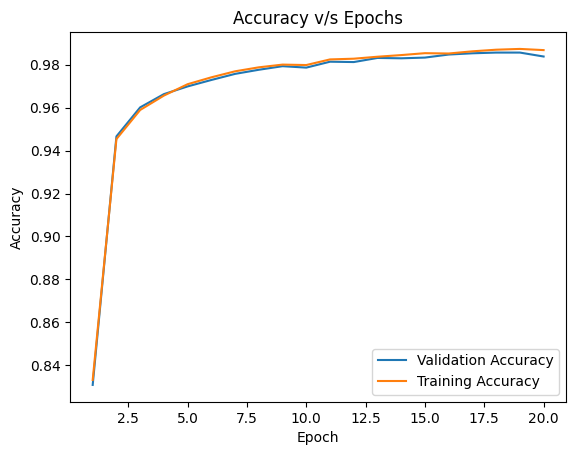

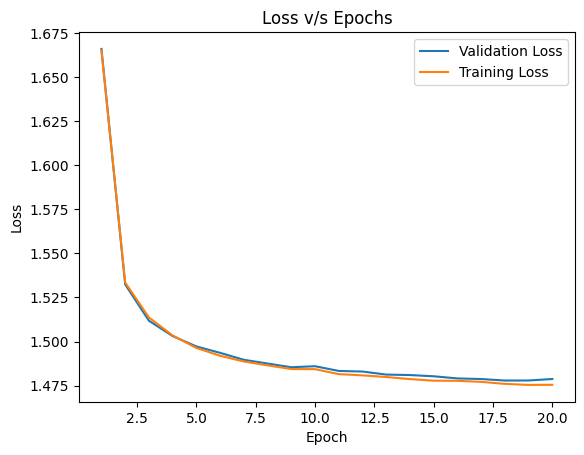

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
cnn = CNN(batch_size=480, learning_rate=1e-3, dropout_rate=0.25, num_epochs=20, kernel_size=3, stride=3, out1=32, out2=64)
train_accuracies, val_accuracies, train_losses, val_losses, val_precision, val_recall, val_f1, conf_matrix = cnn.fit(data2, test)

# Hyperparameter Tuning

In [ ]:
api = wandb.Api()

runs = api.runs("sarthakchittawar/cnn")
count = 0

df = None

while True:
    try:
        run = runs[count]
        count += 1
        if count == 1:
            df = pd.json_normalize([row for row in run.scan_history()])
        else:
            df = pd.concat([df, pd.json_normalize([row for row in run.scan_history()])], axis=0)
    except:
        break

print('Total Runs: ', count)

df = df.sort_values(by=['val_accuracy'], ascending=False)
df

row = df.iloc[0]

best_epoch = row['epoch']
best_lr = row['learning_rate']
best_batch_size = row['batch_size']
best_kernel_size = row['kernel_size']
best_stride = row['stride']
best_out1 = row['out1']
best_out2 = row['out2']
best_dropout_rate = row['dropout_rate']

print('Best Epochs: ', best_epoch)
print('Best Learning Rate: ', best_lr)
print('Best Batch Size: ', best_batch_size)
print('Best Kernel Size: ', best_kernel_size)
print('Best Stride: ', best_stride)
print('Best Out1: ', best_out1)
print('Best Out2: ', best_out2)
print('Best Dropout Rate: ', best_dropout_rate)

print("\nFor Validation Set:")
print('Accuracy: ', row['val_accuracy'])

Total Runs:  141
Best Epochs:  18
Best Learning Rate:  0.001
Best Batch Size:  48
Best Kernel Size:  3
Best Stride:  2
Best Out1:  32
Best Out2:  64
Best Dropout Rate:  0.25

For Validation Set:
Accuracy:  0.9909166666666667


# Testing

Test Accuracy:  0.9913
Per Class Accuracy:
0 :  0.9979591836734694
1 :  0.9964757709251101
2 :  0.9951550387596899
3 :  0.995049504950495
4 :  0.9938900203665988
5 :  0.9899103139013452
6 :  0.9832985386221293
7 :  0.9824902723735409
8 :  0.9876796714579055
9 :  0.9900891972249752
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.98      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg  

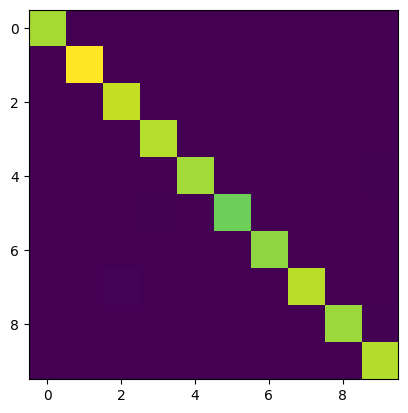

In [ ]:
train_init, val = train_test_split(data2, test_size=0.2)
test = DataLoader(test, shuffle=True)
# print(type(best_batch_size))

# testing on test set
model = CNN_model(best_kernel_size, best_dropout_rate, best_stride, best_out1, best_out2).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
model.train()

epoch = 0

while epoch < best_epoch:
    train = DataLoader(train_init, batch_size=int(best_batch_size), shuffle=True)
    for i, (X, y) in enumerate(train):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        X.detach()
        y.detach()

    epoch += 1

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    count = 0
    conf_matrix = np.zeros((10, 10))

    ytrues = []
    ypreds = []

    for X, y in test:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        _, predicted = torch.max(y_pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        conf_matrix += metrics.confusion_matrix(y.cpu(), predicted.cpu(), labels=np.arange(10))
        ytrues.extend(y.cpu().tolist())
        ypreds.extend(predicted.cpu().tolist())
        X.detach()
        y.detach()
        y_pred.detach()
        count += 1
    test_acc = correct / total
    conf_matrix /= count

    print('Test Accuracy: ', test_acc)

    # per class accuracy
    print('Per Class Accuracy:')
    for i in range(10):
        print(i, ': ', conf_matrix[i][i]/np.sum(conf_matrix[i]))

    clr = metrics.classification_report(ytrues, ypreds)
    print(clr)

    print("Confusion Matrix:")
    plt.imshow(conf_matrix)

# Noisy Dataset

In [15]:
mat = scipy.io.loadmat('mnist-with-awgn.mat')

In [16]:
X_train = mat['train_x'].reshape((mat['train_x'].shape[0], 1, 28, 28))
y_train = mat['train_y']
X_test = mat['test_x'].reshape((mat['test_x'].shape[0], 1, 28, 28))
y_test = mat['test_y']

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

import torch.utils.data
print(X_train.shape)

data = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
test = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long())

(60000, 1, 28, 28)


Training set size: 48000
Validation set size: 12000
Test set size: 10000
Epoch: 1, Train Loss: 2.278530523777008, Val loss: 2.281249177465836, Train Accuracy: 0.18018333333333333, Val Accuracy: 0.17825
Epoch: 2, Train Loss: 2.073295226097107, Val loss: 2.0759049542546273, Train Accuracy: 0.38283333333333336, Val Accuracy: 0.3805
Epoch: 3, Train Loss: 1.9125667643547057, Val loss: 1.91511378394564, Train Accuracy: 0.5451166666666667, Val Accuracy: 0.5435
Epoch: 4, Train Loss: 1.6771976613998414, Val loss: 1.6759020760655403, Train Accuracy: 0.7850666666666667, Val Accuracy: 0.7851666666666667
Epoch: 5, Train Loss: 1.599670602083206, Val loss: 1.5987200471758842, Train Accuracy: 0.8621, Val Accuracy: 0.8625
Epoch: 6, Train Loss: 1.5576572740077972, Val loss: 1.555597560286522, Train Accuracy: 0.9042333333333333, Val Accuracy: 0.9056666666666666
Epoch: 7, Train Loss: 1.5471332132816316, Val loss: 1.5447756477495034, Train Accuracy: 0.915, Val Accuracy: 0.9161666666666667
Epoch: 8, Train L

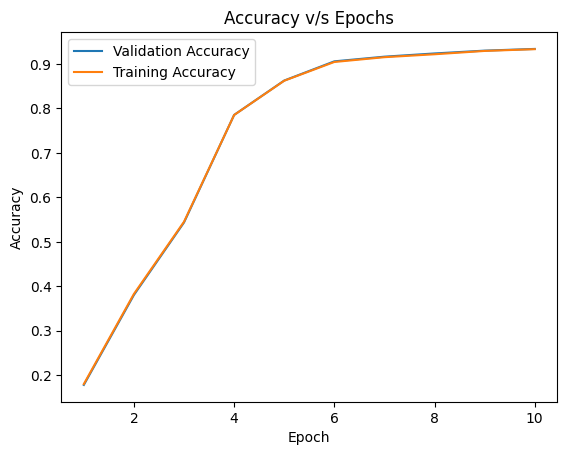

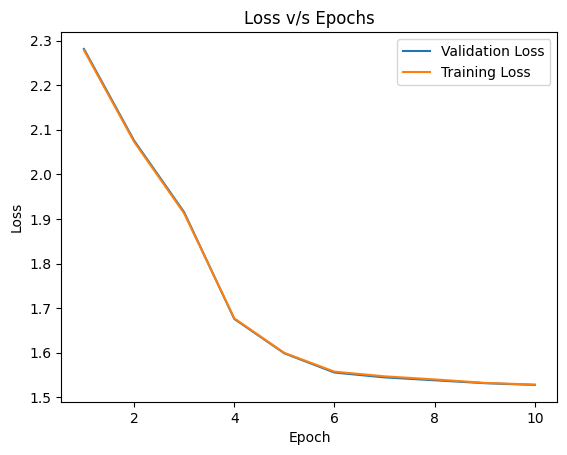

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cnn = CNN(num_epochs=10, batch_size=480, learning_rate=1e-4, dropout_rate=0.5, kernel_size=3, stride=2, out1=32, out2=64)
train_accuracies, val_accuracies, train_losses, val_losses, val_precision, val_recall, val_f1, conf_matrix = cnn.fit(data, test)